In [1]:
import mlflow, numpy as np, tempfile, boto3, os, pickle, xarray as xr
from matplotlib import pyplot as plt
from jax import vmap
mlflow.set_tracking_uri("https://continuum.ergodic.io/experiments/")

In [2]:
exp = mlflow.get_experiment_by_name("opt-64lines")
un_exp = mlflow.get_experiment_by_name("uniform-64lines")
avg_exp = mlflow.get_experiment_by_name("optavg-64lines")
random_phase_exp = mlflow.get_experiment_by_name("randomphaser-64lines")


In [3]:
# filter runs with "temperature" in the mlflow run name
runs = mlflow.search_runs(experiment_names=[exp.name], filter_string="attribute.run_name LIKE '%temperature%'")
un_runs = mlflow.search_runs(experiment_names=[un_exp.name], filter_string="attribute.run_name LIKE '%temperature%'")
avg_runs = mlflow.search_runs(experiment_names=[avg_exp.name], filter_string="attribute.run_name LIKE '%temperature%'")
random_phase_runs = mlflow.search_runs(experiment_names=[random_phase_exp.name], filter_string="attribute.run_name LIKE '%temperature%'")

In [4]:
runs[runs["params.units.reference electron temperature"].str.contains("keV")]

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.system/disk_usage_megabytes,metrics.system/cpu_utilization_percentage,metrics.system/disk_available_megabytes,metrics.system/network_receive_megabytes,...,tags.mlflow_exim.run_info.status,tags.mlflow_exim.mlflow_tag.source.git.commit,tags.mlflow_exim.run_info.run_uuid,tags.mlflow_exim.run_info.lifecycle_stage,tags.mlflow_exim.run_info.experiment_id,tags.mlflow_exim.run_info.start_time,tags.mlflow_exim.mlflow_tag.runName,tags.mlflow_exim.run_info.run_id,tags.mlflow_exim.run_info._end_time,tags.mlflow_exim.mlflow_tag.source.type
82,2d769d8bffa6457893ae877840b6adbd,181417,FINISHED,s3://public-ergodic-continuum/181417/2d769d8bf...,2025-02-03 22:11:48.684000+00:00,2025-02-03 23:11:46.476000+00:00,1388.8,2.7,268835.0,6465.655823,...,RUNNING,60eb723c1202769d5607ab84f0588c6c45940eda,518332fa8e5b45adbb59adceba7a3186,active,321676851237208016,1738620465142,temperature=3.0keV-gsl=450um-intensity=1.0e15 ...,518332fa8e5b45adbb59adceba7a3186,2025-02-03 14:07:45,LOCAL
83,1a0ead08e58641f79b15fbc479e45767,181417,FINISHED,s3://public-ergodic-continuum/181417/1a0ead08e...,2025-02-03 18:39:55.557000+00:00,2025-02-03 22:00:47.015000+00:00,1382.1,2.1,268841.7,7574.232984,...,FINISHED,60eb723c1202769d5607ab84f0588c6c45940eda,45d78e6c1bb4432099c4cb36b9bebb59,active,321676851237208016,1738607888193,temperature=3.0keV-gsl=450um-intensity=1.0e15 ...,45d78e6c1bb4432099c4cb36b9bebb59,2025-02-03 10:38:08,LOCAL


In [5]:
runs.iloc[:2]

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.system/disk_usage_megabytes,metrics.system/cpu_utilization_percentage,metrics.system/disk_available_megabytes,metrics.system/network_receive_megabytes,...,tags.mlflow_exim.run_info.status,tags.mlflow_exim.mlflow_tag.source.git.commit,tags.mlflow_exim.run_info.run_uuid,tags.mlflow_exim.run_info.lifecycle_stage,tags.mlflow_exim.run_info.experiment_id,tags.mlflow_exim.run_info.start_time,tags.mlflow_exim.mlflow_tag.runName,tags.mlflow_exim.run_info.run_id,tags.mlflow_exim.run_info._end_time,tags.mlflow_exim.mlflow_tag.source.type
0,8c721abde7574aedbc11eeccac7f62bb,181417,FINISHED,s3://public-ergodic-continuum/181417/8c721abde...,2025-02-26 01:38:54.643000+00:00,2025-02-26 03:02:27.289000+00:00,1059.0,0.9,269095.3,1880.584226,...,None,None,None,None,None,None,None,None,None,None
1,810a596aca77466e93dba797febc60b3,181417,FINISHED,s3://public-ergodic-continuum/181417/810a596ac...,2025-02-25 23:27:20.669000+00:00,2025-02-26 00:37:32.479000+00:00,1044.7,1.2,269109.5,3754.095375,...,None,None,None,None,None,None,None,None,None,None


In [6]:
stored_loss_for_nan = runs.iloc[1]["metrics.loss"]
stored_loss_for_bigval = runs.iloc[0]["metrics.loss"]

In [7]:
# get temperatures, intensities, gsls " eV", " W/cm^2", " um"
runs = runs[2:-2]
make_arr = lambda col_of_int, substring: np.array([float(val.strip(substring)) for val in col_of_int])
temperatures = make_arr(runs["params.units.reference electron temperature"].unique(), "eV")
intensities = make_arr(runs["params.units.laser intensity"].unique(), "W/cm^2")
gsls = make_arr(runs["params.density.gradient scale length"].unique(), "um")

temperatures.sort(), intensities.sort(), gsls.sort()

(None, None, None)

In [8]:
loss_values = xr.DataArray(np.zeros((len(temperatures), len(intensities), len(gsls))), coords=(temperatures, intensities, gsls), dims=["temperature", "intensity", "gsl"])
un_loss_values = xr.DataArray(np.zeros((len(temperatures), len(intensities), len(gsls))), coords=(temperatures, intensities, gsls), dims=["temperature", "intensity", "gsl"])
avg_loss_values = xr.DataArray(np.zeros((len(temperatures), len(intensities), len(gsls))), coords=(temperatures, intensities, gsls), dims=["temperature", "intensity", "gsl"])
random_phase_loss_values = xr.DataArray(np.zeros((len(temperatures), len(intensities), len(gsls))), coords=(temperatures, intensities, gsls), dims=["temperature", "intensity", "gsl"])
amplitudes = np.zeros((len(temperatures), len(intensities), len(gsls), 64))
phases = np.zeros((len(temperatures), len(intensities), len(gsls), 64))

s3 = boto3.client("s3")

with tempfile.TemporaryDirectory() as td:
    for i, temp in enumerate(temperatures):
        for j, intensity in enumerate(intensities):
            for k, gsl in enumerate(gsls):
                run = runs[(runs["params.units.reference electron temperature"] == f"{temp} eV") & 
                        (runs["params.units.laser intensity"] == f"{intensity} W/cm^2") & 
                        (runs["params.density.gradient scale length"] == f"{gsl} um")]
                

                # if (temp == 2000) and (intensity == 4e14) and (gsl == 1400/3):
                #     print(run) 
                #     print(run["metrics.loss"])
                # loss_values[i, j, k] = run["metrics.loss"].values[0]    
                loc_dict = {"temperature": temp, "intensity": intensity, "gsl": gsl}
                loss_values.loc[loc_dict] = run["metrics.loss"].values[0]

                un_run = un_runs[(un_runs["params.units.reference electron temperature"] == f"{temp} eV") &
                                (un_runs["params.units.laser intensity"] == f"{intensity} W/cm^2") &
                                (un_runs["params.density.gradient scale length"] == f"{gsl} um")]
                un_loss_values.loc[loc_dict] = un_run["metrics.loss"].values[0]

                avg_run = avg_runs[(avg_runs["params.units.reference electron temperature"] == f"{temp} eV") &
                                (avg_runs["params.units.laser intensity"] == f"{intensity} W/cm^2") &
                                (avg_runs["params.density.gradient scale length"] == f"{gsl} um")]      
                avg_loss_values.loc[loc_dict] = np.mean(avg_run["metrics.loss"].dropna().values)#[0]

                random_phase_run = random_phase_runs[(random_phase_runs["params.units.reference electron temperature"] == f"{temp} eV") &
                                (random_phase_runs["params.units.laser intensity"] == f"{intensity} W/cm^2") &
                                (random_phase_runs["params.density.gradient scale length"] == f"{gsl} um")]
                # print(loc_dict)
                random_phase_loss_values.loc[loc_dict] = random_phase_run["metrics.loss"].values[0]

loss_values.loc[{"temperature": 3500, "intensity": 4e14, "gsl": 600}] = stored_loss_for_nan
loss_values.loc[{"temperature": 2000, "intensity": 7e14}][1] = stored_loss_for_bigval


In [9]:
loss_values

<xarray.DataArray (temperature: 5, intensity: 4, gsl: 4)> Size: 640B
array([[[-2.88255024, -2.84533596, -2.86035419, -2.86569834],
        [-2.66092014, -2.68198061, -2.44761801, -2.5465374 ],
        [-1.71102691, -0.30910972,  0.9387455 ,  3.88465858],
        [ 1.18383729,  3.63681817,  8.64456654, 13.44519234]],

       [[-3.05915356, -3.05414033, -3.07157278, -3.05419111],
        [-2.92535543, -2.93866682, -2.66637135, -2.71759272],
        [-1.83865452, -1.24397802,  0.14936818,  2.09030056],
        [-0.84785432,  1.33327901,  4.77228737,  7.05363369]],

       [[-3.24786615, -3.23910952, -3.20090842, -3.21296096],
        [-3.21488404, -3.07655668, -3.07751107, -2.96938872],
        [-2.6761663 , -1.28533256, -1.14078319,  1.07964754],
        [-1.94638681,  1.91447806,  4.32978296,  4.58308172]],

       [[-3.30615902, -3.34976077, -3.3643024 , -3.33029556],
        [-3.31977868, -3.27329493, -3.26643825, -3.19848323],
        [-2.97941589, -2.72100163, -2.17097044, -0.50514096],
        [-2.52573633, -0.51253188,  0.81017882,  2.9364171 ]],

       [[-3.47024035, -3.45736241, -3.43402362, -3.42213869],
        [-3.44570184, -3.41321421, -3.3968854 , -3.33687544],
        [-3.25004244, -2.65072536, -1.71669948, -1.47645164],
        [-2.57324147, -2.7349925 ,  0.21514133,  2.26011157]]])
Coordinates:
  * temperature  (temperature) float64 40B 2e+03 2.5e+03 3e+03 3.5e+03 4e+03
  * intensity    (intensity) float64 32B 1e+14 4e+14 7e+14 1e+15
  * gsl          (gsl) float64 32B 200.0 333.3 466.7 600.0

In [10]:
un_loss_values

<xarray.DataArray (temperature: 5, intensity: 4, gsl: 4)> Size: 640B
array([[[-2.86054945, -2.84822607, -2.84309912, -2.83544183],
        [-1.94310749, -1.15067554, -0.74518049, -0.58066612],
        [ 0.55724734,  2.94453907,  5.39278555,  7.24076986],
        [ 3.58571601,  8.52985382, 11.73624802, 15.12111664]],

       [[-3.05014801, -3.06583571, -3.0476861 , -3.05236888],
        [-2.60102034, -2.39250064, -1.63300824, -1.18922544],
        [-0.44877863,  1.79372227,  3.69153738,  5.08349895],
        [ 2.31696224,  6.34495306, 10.10295296, 12.41400146]],

       [[-3.21861362, -3.19929838, -3.21643996, -3.20810318],
        [-2.83108282, -2.42792034, -2.4559288 , -1.77598691],
        [-1.26297426,  0.56346905,  2.39200807,  3.29704762],
        [ 0.53301018,  3.33982229,  7.22547722,  8.89987373]],

       [[-3.38379574, -3.35765862, -3.35697246, -3.3389318 ],
        [-3.19285321, -2.6788249 , -2.47387481, -2.58685637],
        [-1.51578069, -0.37635368,  1.76439428,  2.38570857],
        [-0.49372616,  2.62340617,  4.33659649,  7.56520462]],

       [[-3.4795599 , -3.46658564, -3.46756005, -3.47647095],
        [-3.33856797, -3.1030283 , -2.92049646, -2.55817008],
        [-2.29337549, -0.77872151, -0.32534337,  1.54051852],
        [-0.85970861,  0.86128724,  3.54698801,  5.49108171]]])
Coordinates:
  * temperature  (temperature) float64 40B 2e+03 2.5e+03 3e+03 3.5e+03 4e+03
  * intensity    (intensity) float64 32B 1e+14 4e+14 7e+14 1e+15
  * gsl          (gsl) float64 32B 200.0 333.3 466.7 600.0

In [11]:
avg_loss_values

<xarray.DataArray (temperature: 5, intensity: 4, gsl: 4)> Size: 640B
array([[[-2.84030719, -2.83729011, -2.82880032, -2.82195967],
        [-2.47537339, -2.30587375, -2.07248431, -1.63847339],
        [-1.37298872, -0.1968933 ,  1.62227288,  4.75301695],
        [ 0.99531445,  3.59098899,  7.66211283, 12.64300442]],

       [[-3.05636221, -3.04168695, -3.02142847, -3.02250129],
        [-2.7569176 , -2.65795821, -2.50338417, -2.33994848],
        [-1.86706737, -1.03110042,  0.50152351,  1.20309916],
        [-0.03027275,  1.98884931,  4.93738616,  7.52031219]],

       [[-3.22546321, -3.20761907, -3.19118959, -3.20623517],
        [-3.0086959 , -2.92441231, -2.82215273, -2.68236727],
        [-2.45601022, -1.44046286, -1.08551145,  0.1861054 ],
        [-1.11695069,  1.18370664,  3.00622743,  5.50900602]],

       [[-3.35047752, -3.35060757, -3.32917541, -3.34207195],
        [-3.185956  , -3.16310096, -3.09721065, -3.0502125 ],
        [-2.68010312, -2.35848153, -1.91567579, -1.13732323],
        [-1.44158277, -0.19678414,  1.41386527,  2.82675248]],

       [[-3.49289274, -3.46624088, -3.46409899, -3.48131555],
        [-3.40803862, -3.33211434, -3.31690931, -3.29175383],
        [-3.10555995, -2.88827044, -2.21256346, -1.7997638 ],
        [-2.3956151 , -1.14801285,  0.41798362,  1.26840141]]])
Coordinates:
  * temperature  (temperature) float64 40B 2e+03 2.5e+03 3e+03 3.5e+03 4e+03
  * intensity    (intensity) float64 32B 1e+14 4e+14 7e+14 1e+15
  * gsl          (gsl) float64 32B 200.0 333.3 466.7 600.0

In [12]:
random_phase_loss_values

<xarray.DataArray (temperature: 5, intensity: 4, gsl: 4)> Size: 640B
array([[[-2.88631821e+00, -2.86375737e+00, -2.87746978e+00,
         -2.88188314e+00],
        [-2.56192827e+00, -2.47894335e+00, -1.91208315e+00,
         -2.01474786e+00],
        [-2.75337458e-01,  2.43257594e+00,  3.57947683e+00,
          6.66136551e+00],
        [ 2.44529700e+00,  5.64418221e+00,  1.07449131e+01,
          1.63970985e+01]],

       [[-3.09387898e+00, -3.07573342e+00, -3.07283306e+00,
         -3.05464745e+00],
        [-2.84930539e+00, -2.92463160e+00, -2.44214225e+00,
         -2.14270306e+00],
        [-8.51587057e-01, -3.71873379e-03,  2.21592402e+00,
          3.55413747e+00],
        [ 5.50399184e-01,  2.70187998e+00,  7.36222935e+00,
          8.14562035e+00]],

       [[-3.23218775e+00, -3.24088979e+00, -3.23038840e+00,
         -3.20550752e+00],
...
        [-4.41825330e-01,  4.01567268e+00,  6.67340088e+00,
          1.01057644e+01]],

       [[-3.37478352e+00, -3.35098600e+00, -3.35838318e+00,
         -3.36294889e+00],
        [-3.33029151e+00, -3.20553327e+00, -3.16112757e+00,
         -2.92207146e+00],
        [-2.46801972e+00, -1.61207652e+00, -2.31062144e-01,
          4.34904665e-01],
        [-1.59815717e+00,  1.35069478e+00,  3.40121460e+00,
          6.62481117e+00]],

       [[-3.50440025e+00, -3.48226047e+00, -3.46578646e+00,
         -3.47188854e+00],
        [-3.43296146e+00, -3.35938072e+00, -3.24871778e+00,
         -3.10445881e+00],
        [-2.91000700e+00, -1.94944143e+00, -1.88218534e-01,
          2.48085707e-01],
        [-2.06476688e+00, -1.62502789e+00,  2.06193590e+00,
          4.36291409e+00]]])
Coordinates:
  * temperature  (temperature) float64 40B 2e+03 2.5e+03 3e+03 3.5e+03 4e+03
  * intensity    (intensity) float64 32B 1e+14 4e+14 7e+14 1e+15
  * gsl          (gsl) float64 32B 200.0 333.3 466.7 600.0

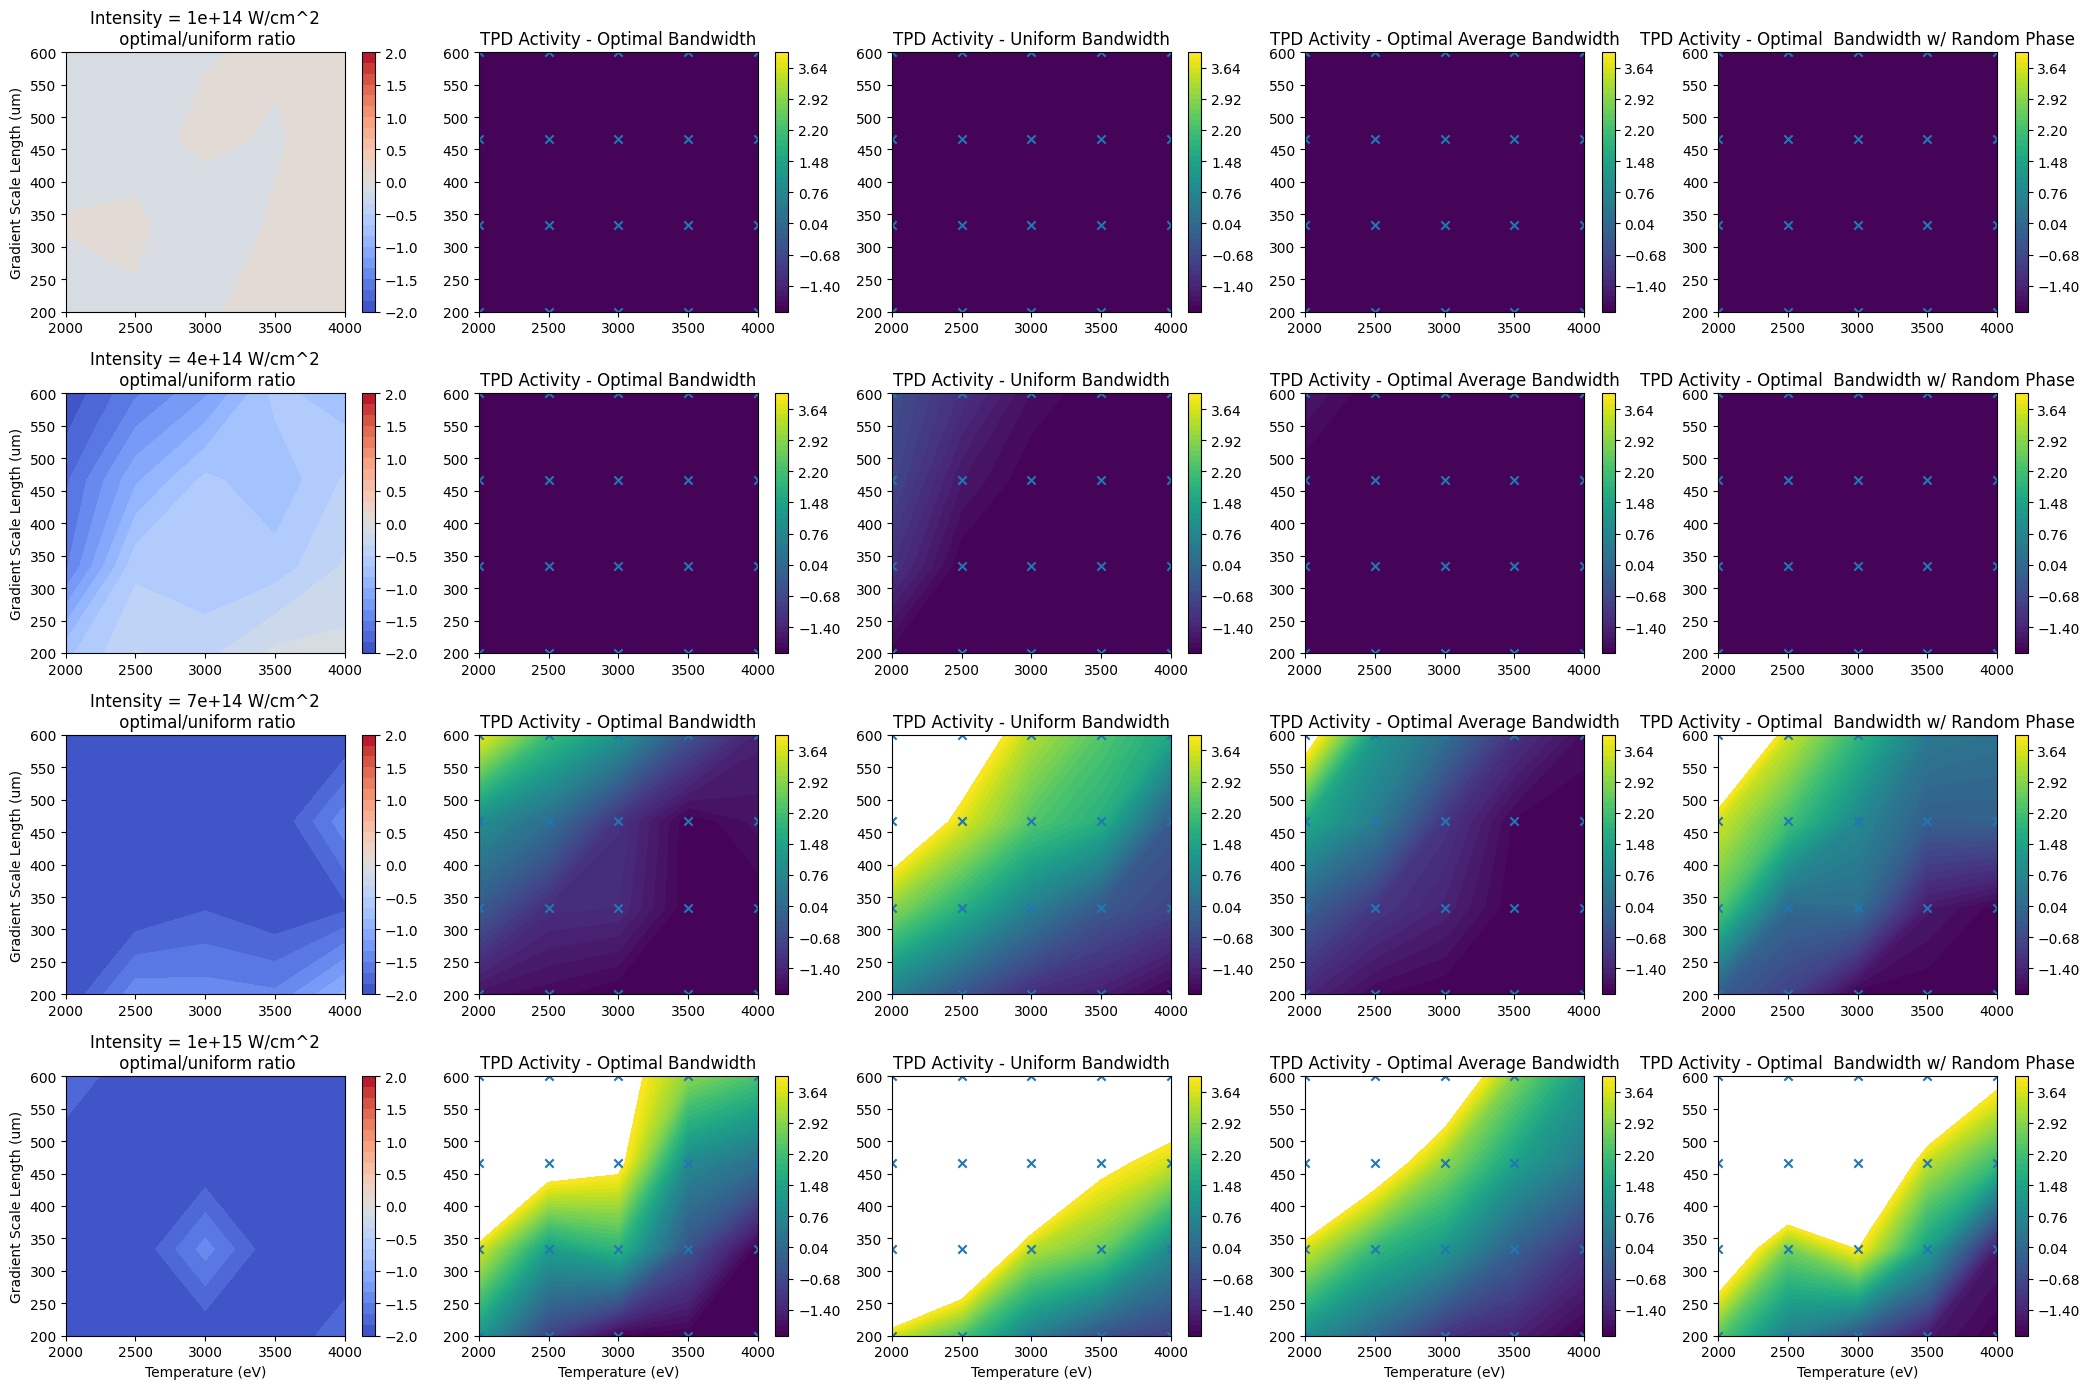

In [13]:
# loss_values = xr.open_dataarray("../results/loss_values.nc")
# un_loss_values = xr.open_dataarray("../results/num_color_loss_values.nc")

ratios =  loss_values-un_loss_values

fig, ax = plt.subplots(4, 5, figsize=(21, 14), tight_layout=True)
for _intind, intt in enumerate(intensities):
    plot_arr = xr.where(ratios.loc[{"intensity": intt}] < -2, ratios.loc[{"intensity": intt}]*0-2, ratios.loc[{"intensity": intt}])
    # print(plot_arr)
    # plot_arr.plot(ax=ax[_intind, 0], cmap="coolwarm") #, levels=25)
    c = ax[_intind, 0].contourf(temperatures, gsls, plot_arr.data.T, np.linspace(-2, 2, 25), cmap="coolwarm")
    fig.colorbar(c)
    ax[_intind, 0].set_title("Intensity = %.0e W/cm^2" % intensities[_intind] + "\n optimal/uniform ratio")
    
    threshold_val = -2

    clevs=np.linspace(-2, 4, 51) 

    plot_arr = xr.where(loss_values.loc[{"intensity": intt}] < threshold_val, threshold_val, loss_values.loc[{"intensity": intt}])
    c = ax[_intind, 1].contourf(temperatures, gsls, plot_arr.T, 25, cmap="viridis", levels=clevs)
    tgrid, gslgrid = np.meshgrid(temperatures, gsls)
    ax[_intind, 1].scatter(tgrid.flatten(), gslgrid.flatten(), marker="x")
    fig.colorbar(c)
    ax[_intind, 1].set_title("TPD Activity - Optimal Bandwidth")

    # if _intind == 1:
    #     print(intensities[_intind], plot_arr.T)
        # print(loss_values[:, :, _intind])

    plot_arr = xr.where(un_loss_values.loc[{"intensity": intt}] < threshold_val, threshold_val, un_loss_values.loc[{"intensity": intt}])
    c = ax[_intind, 2].contourf(temperatures, gsls, plot_arr.T, 25, cmap="viridis", levels=clevs)
    ax[_intind, 2].scatter(tgrid.flatten(), gslgrid.flatten(), marker="x")
    fig.colorbar(c)
    ax[_intind, 2].set_title("TPD Activity - Uniform Bandwidth")

    plot_arr = xr.where(avg_loss_values.loc[{"intensity": intt}] < threshold_val, threshold_val, avg_loss_values.loc[{"intensity": intt}])
    c = ax[_intind, 3].contourf(temperatures, gsls, plot_arr.T, 25, cmap="viridis", levels=clevs)
    ax[_intind, 3].scatter(tgrid.flatten(), gslgrid.flatten(), marker="x")
    fig.colorbar(c)
    ax[_intind, 3].set_title("TPD Activity - Optimal Average Bandwidth")

    plot_arr = xr.where(random_phase_loss_values.loc[{"intensity": intt}] < threshold_val, threshold_val, random_phase_loss_values.loc[{"intensity": intt}])
    c = ax[_intind, 4].contourf(temperatures, gsls, plot_arr.T, 25, cmap="viridis", levels=clevs)
    ax[_intind, 4].scatter(tgrid.flatten(), gslgrid.flatten(), marker="x")
    fig.colorbar(c)
    ax[_intind, 4].set_title("TPD Activity - Optimal  Bandwidth w/ Random Phase")

ax[0, 0].set_ylabel("Gradient Scale Length (um)")
ax[1, 0].set_ylabel("Gradient Scale Length (um)")
ax[2, 0].set_ylabel("Gradient Scale Length (um)")
ax[3, 0].set_ylabel("Gradient Scale Length (um)")
ax[-1, 0].set_xlabel("Temperature (eV)")
ax[-1, 1].set_xlabel("Temperature (eV)")
ax[-1, 2].set_xlabel("Temperature (eV)")
ax[-1, 3].set_xlabel("Temperature (eV)")
ax[-1, 4].set_xlabel("Temperature (eV)")

fig.savefig("./bw_comparison.png", bbox_inches="tight")

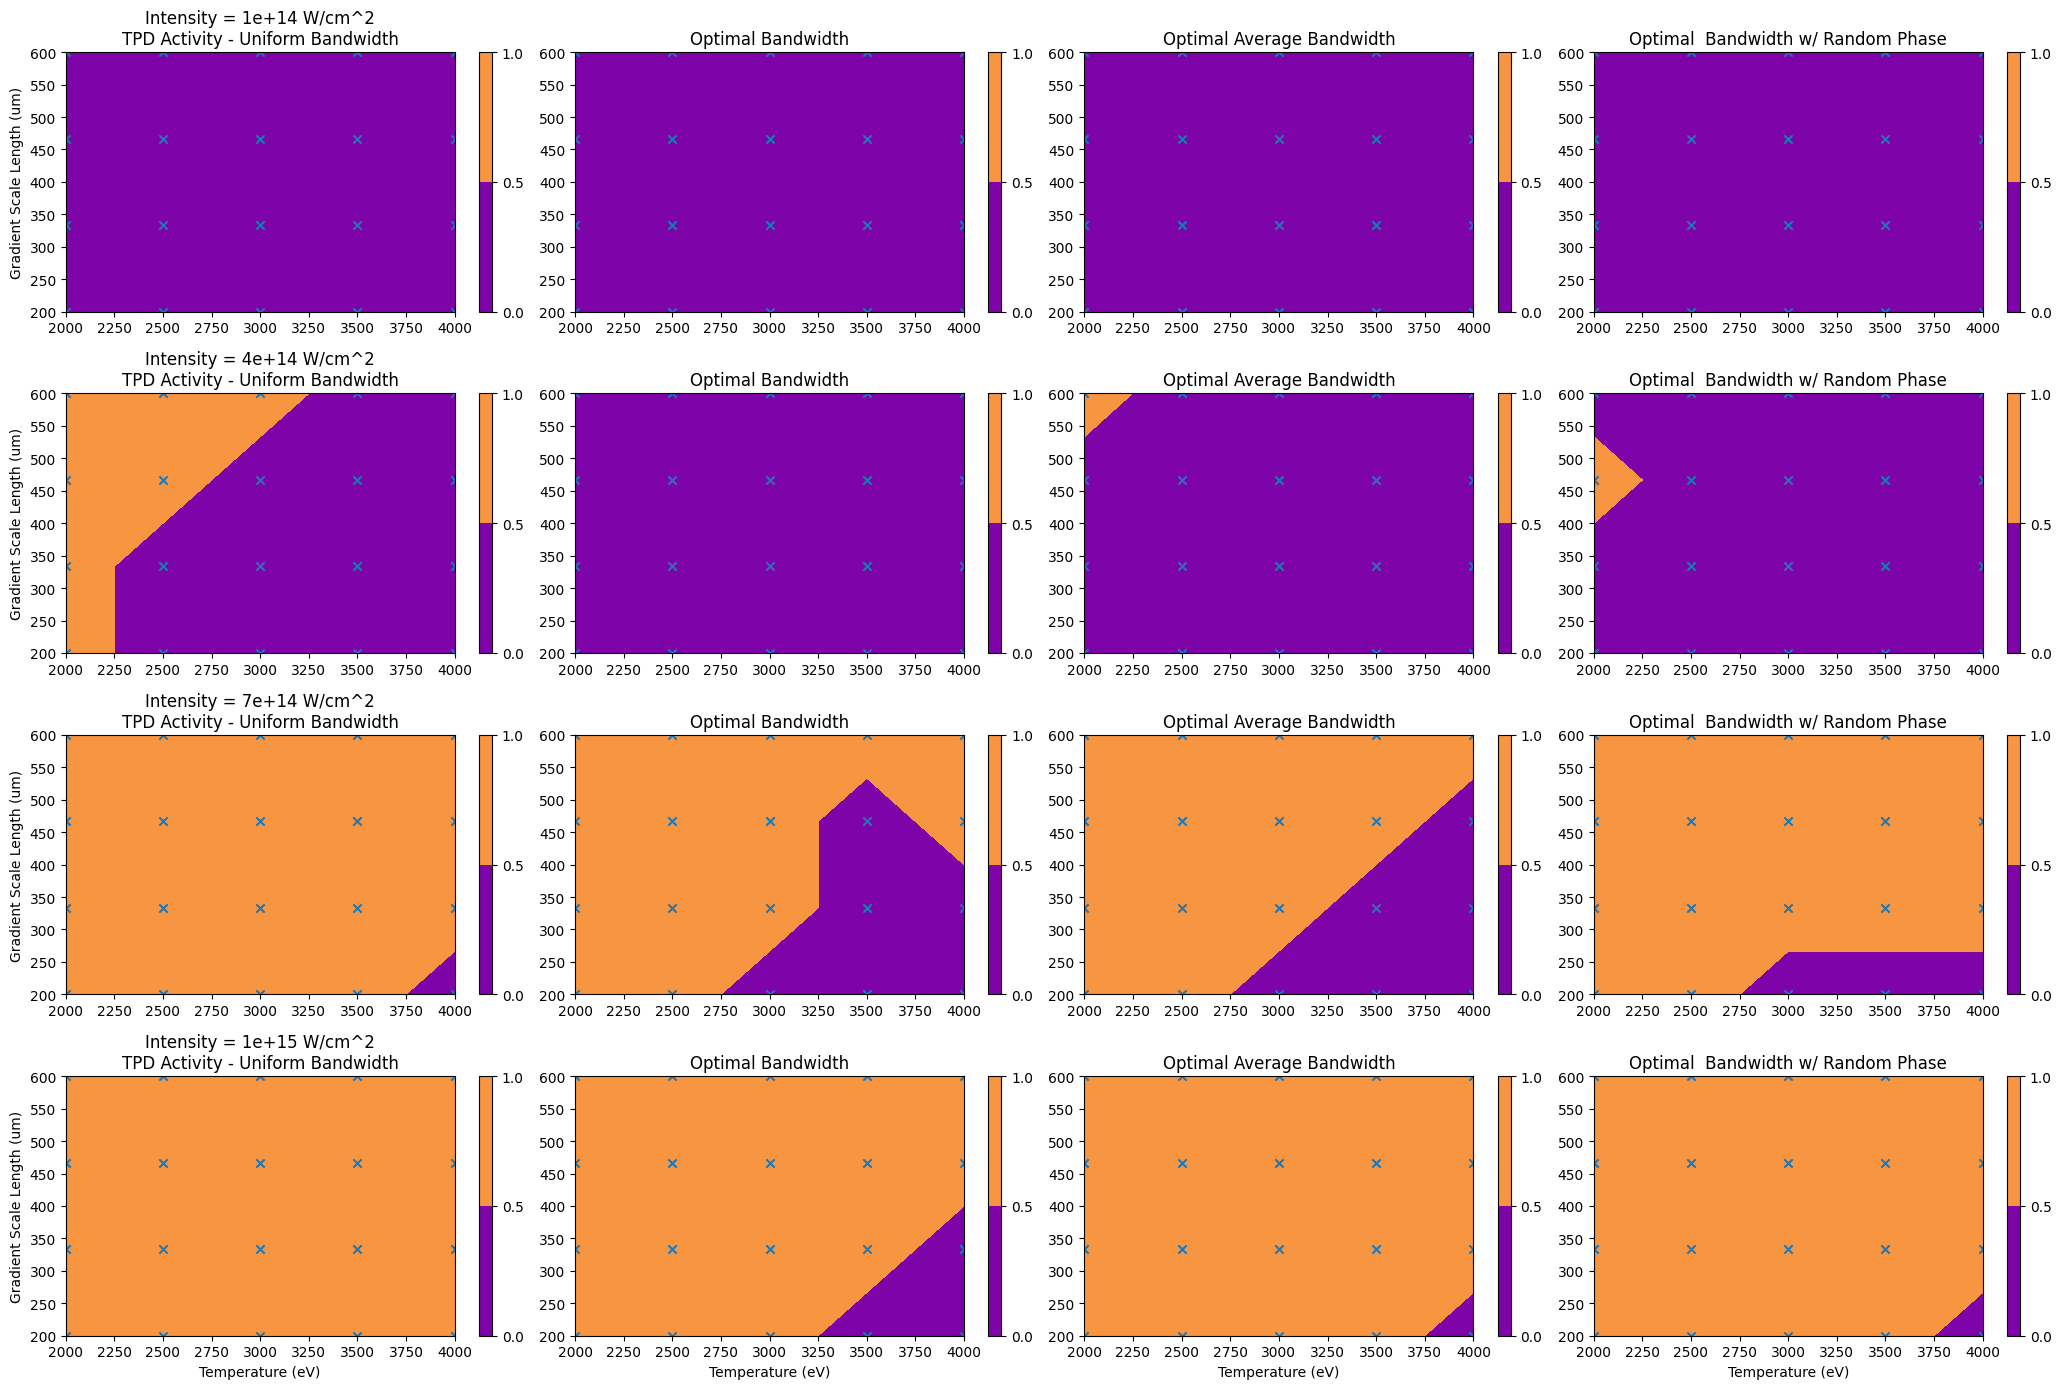

In [14]:
ratios =  loss_values-un_loss_values

fig, ax = plt.subplots(4, 4, figsize=(21, 14), tight_layout=True)
for _intind, intt in enumerate(intensities):
    # plot_arr = xr.where(ratios.loc[{"intensity": intt}] < -2, ratios.loc[{"intensity": intt}]*0-2, ratios.loc[{"intensity": intt}])
    # # print(plot_arr)
    # # plot_arr.plot(ax=ax[_intind, 0], cmap="coolwarm") #, levels=25)
    # c = ax[_intind, 0].contourf(temperatures, gsls, plot_arr.data.T, np.linspace(-2, 2, 25), cmap="coolwarm")
    # fig.colorbar(c)
    # ax[_intind, 0].set_title("Intensity = %.0e W/cm^2" % intensities[_intind] + "\n optimal/uniform ratio")
    
    threshold_val = -2

    clevs=np.linspace(0, 1, 3)
    tgrid, gslgrid = np.meshgrid(temperatures, gsls)

    

    # if _intind == 1:
    #     print(intensities[_intind], plot_arr.T)
        # print(loss_values[:, :, _intind])

    plot_arr = xr.where(un_loss_values.loc[{"intensity": intt}] < threshold_val, threshold_val*0, 1+0*un_loss_values.loc[{"intensity": intt}])
    c = ax[_intind, 0].contourf(temperatures, gsls, plot_arr.T, 25, cmap="plasma", levels=clevs)
    ax[_intind, 0].scatter(tgrid.flatten(), gslgrid.flatten(), marker="x")
    fig.colorbar(c)
    ax[_intind, 0].set_title("Intensity = %.0e W/cm^2" % intensities[_intind] + "\nTPD Activity - Uniform Bandwidth")

    plot_arr = xr.where(loss_values.loc[{"intensity": intt}] < threshold_val, threshold_val*0, 1+0*loss_values.loc[{"intensity": intt}])
    c = ax[_intind, 1].contourf(temperatures, gsls, plot_arr.T, 25, cmap="plasma", levels=clevs)
    ax[_intind, 1].scatter(tgrid.flatten(), gslgrid.flatten(), marker="x")
    fig.colorbar(c)
    ax[_intind, 1].set_title("Optimal Bandwidth")

    plot_arr = xr.where(avg_loss_values.loc[{"intensity": intt}] < threshold_val, threshold_val*0, 1+0*avg_loss_values.loc[{"intensity": intt}])
    c = ax[_intind, 2].contourf(temperatures, gsls, plot_arr.T, 25, cmap="plasma", levels=clevs)
    ax[_intind, 2].scatter(tgrid.flatten(), gslgrid.flatten(), marker="x")
    fig.colorbar(c)
    ax[_intind, 2].set_title("Optimal Average Bandwidth")

    plot_arr = xr.where(random_phase_loss_values.loc[{"intensity": intt}] < threshold_val, threshold_val*0, 1+0*random_phase_loss_values.loc[{"intensity": intt}])
    c = ax[_intind, 3].contourf(temperatures, gsls, plot_arr.T, 25, cmap="plasma", levels=clevs)
    ax[_intind, 3].scatter(tgrid.flatten(), gslgrid.flatten(), marker="x")
    fig.colorbar(c)
    ax[_intind, 3].set_title("Optimal  Bandwidth w/ Random Phase")

ax[0, 0].set_ylabel("Gradient Scale Length (um)")
ax[1, 0].set_ylabel("Gradient Scale Length (um)")
ax[2, 0].set_ylabel("Gradient Scale Length (um)")
ax[3, 0].set_ylabel("Gradient Scale Length (um)")
ax[-1, 0].set_xlabel("Temperature (eV)")
ax[-1, 1].set_xlabel("Temperature (eV)")
ax[-1, 2].set_xlabel("Temperature (eV)")
ax[-1, 3].set_xlabel("Temperature (eV)")
# ax[-1, 4].set_xlabel("Temperature (eV)")

fig.savefig("./bw_comparison.png", bbox_inches="tight")

## Download Drivers

In [6]:
amplitudes = np.zeros((len(temperatures), len(intensities), len(gsls), 64))
phases = np.zeros((len(temperatures), len(intensities), len(gsls), 64))
delta_omega = np.linspace(-0.015, 0.015, 64)

amplitudes_xr = xr.DataArray(amplitudes, coords=(temperatures, intensities, gsls, delta_omega), dims=["temperature", "intensity", "gsl", "delta_omega"])
phases_xr = xr.DataArray(phases, coords=(temperatures, intensities, gsls, delta_omega), dims=["temperature", "intensity", "gsl", "delta_omega"])

s3 = boto3.client("s3")

with tempfile.TemporaryDirectory() as td:
    for i, temp in enumerate(temperatures):
        for j, intensity in enumerate(intensities):
            for k, gsl in enumerate(gsls):
                run = runs[(runs["params.units.reference electron temperature"] == f"{temp} eV") & 
                        (runs["params.units.laser intensity"] == f"{intensity} W/cm^2") & 
                        (runs["params.density.gradient scale length"] == f"{gsl} um")]
                

                # the above run is a parent run, find the latest child run
                parent_run_id = run["run_id"].values[0]
                child_runs = mlflow.search_runs(experiment_ids=[exp.experiment_id], filter_string=f"tags.mlflow.parentRunId = '{parent_run_id}'")
                if len(child_runs) == 0:
                    pass
                else:
                    child_run = child_runs.sort_values("start_time", ascending=False).iloc[0]
                    temp_path = os.path.join(td, "temp_driver.pkl")
                    object_key = f"{exp.experiment_id}/{child_run['run_id']}/artifacts/driver/used_driver.pkl"
                    s3.download_file("public-ergodic-continuum", object_key, temp_path)
                    
                    with open(temp_path, "rb") as f:
                        this_driver = pickle.load(f)
                        loc_dict = {"temperature": temp, "intensity": intensity, "gsl": gsl}
                        amplitudes_xr.loc[loc_dict] = this_driver["E0"]["intensities"]
                        phases_xr.loc[loc_dict] = this_driver["E0"]["phases"]

# delta_omega = this_driver["E0"]["delta_omega"]


In [7]:
optimal_bw = xr.Dataset({"amplitudes": amplitudes_xr, "phases": phases_xr})
optimal_bw.to_netcdf("optimal_bw.nc")

In [9]:
mean_delta_omega = np.sum(amplitudes[..., :] * delta_omega, axis=-1)
mean_delta_omega_2 = np.sqrt(np.sum(amplitudes[..., :] * delta_omega**2, axis=-1))
mean_delta_omega_22 = np.sqrt(np.sum(amplitudes[..., :] * (delta_omega[None, None, None, :]-mean_delta_omega[..., None])**2, axis=-1))


Text(0.5, 0, '$\\Delta \\omega$ (%)')

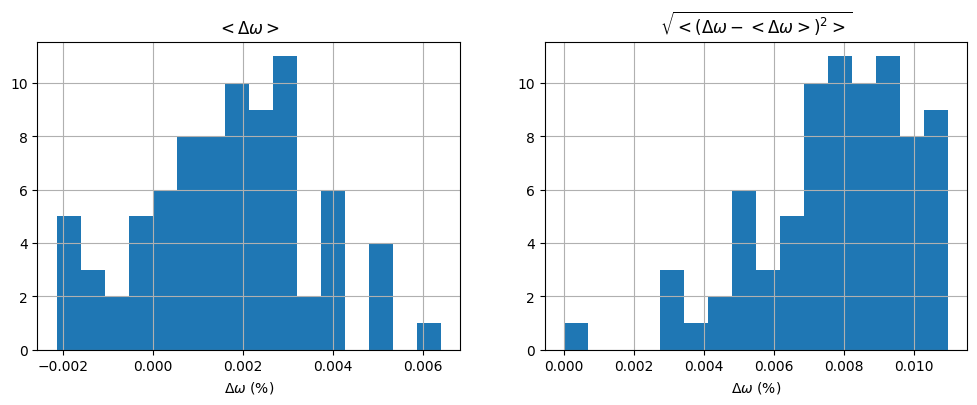

In [19]:
fig, ax = plt.subplots(1, 2,figsize=(12, 4))
ax[0].hist(mean_delta_omega.flatten(),16)
ax[0].grid()
ax[0].set_title(r"$<\Delta \omega>$")
ax[0].set_xlabel(r"$\Delta \omega$ (%)")

ax[1].hist(mean_delta_omega_22.flatten(),16)
ax[1].grid()
ax[1].set_title(r"$\sqrt{<(\Delta \omega - <\Delta \omega>)^2>}$")
ax[1].set_xlabel(r"$\Delta \omega$ (%)")

In [8]:
from adept import ergoExo
from ml4tpd.module import TPDModule
import yaml

In [ ]:
from jax import jit
@jit
def get_one_xprofile(_t, _y, _light_wave):
    return exo.adept_module.diffeqsolve_quants["terms"].vector_field.light.laser_update(_t, _y, _light_wave)[:, 0, 1]

Ignoring xmax and xmin and using the density gradient scale length to set the grid size
Grid size = L / 0.25 * (nmax - nmin) =  239.99999999999994 um


/global/u2/a/archis/adept/adept/_lpse2d/helpers.py:271: RuntimeWarning: divide by zero encountered in divide
  one_over_ksq = np.array(1.0 / (cfg_grid["kx"][:, None] ** 2.0 + cfg_grid["ky"][None, :] ** 2.0))


In [211]:
nc = 64
un_nc = 8
this_temp = 2000
this_int = 4e14
this_gsl = 600

nt = 512
num_phases = 16


loc_dict = {"temperature": this_temp, "intensity": this_int, "gsl": this_gsl}
amplitudes = amplitudes_xr.loc[loc_dict].values
phases = phases_xr.loc[loc_dict].values
un_dw = np.linspace(-0.015, 0.015, un_nc)

light_wave = {"delta_omega": delta_omega, "phases": phases, "intensities": amplitudes} 
un_light_wave = [{"delta_omega": un_dw, "phases": np.random.uniform(-np.pi, np.pi, un_nc), "intensities": np.ones(un_nc)/un_nc} for _ in range(num_phases)]

In [ ]:
from tqdm import tqdm

# get config 
parent_runs = runs[runs["params.density.gradient scale length"] == f"{this_gsl:.1f} um"]
artifact_path = parent_runs["artifact_uri"].values[0]
artifact_path += "/config.yaml"
s3.download_file("public-ergodic-continuum", artifact_path[30:], "./config.yaml")
with open("./config.yaml", "r") as fi:
    config = yaml.safe_load(fi)

exo = ergoExo()
modules = exo._setup_(config, None, TPDModule, log=False)

nx = config["grid"]["nx"]
tmin, tmax = 4, 5

tax = np.linspace(tmin, tmax, nt)
y = exo.adept_module.state
e0_vs_t = np.zeros((nt, nx), dtype=np.complex64)
une0_vs_t = np.zeros((nt, nx, num_phases), dtype=np.complex64)

from jax import jit
@jit
def get_one_xprofile(_t, _y, _light_wave):
    return exo.adept_module.diffeqsolve_quants["terms"].vector_field.light.laser_update(_t, _y, _light_wave)[:, 0, 1]


for i, t in enumerate(tax):
    e0_vs_t[i] = get_one_xprofile(t, y, light_wave)
    for j in range(num_phases):
        une0_vs_t[i, :, j] = get_one_xprofile(t, y, un_light_wave[j])
    

dt = tax[1]-tax[0]
w0_xt = np.gradient(np.unwrap(np.angle(e0_vs_t), axis=0), axis=0)/dt
un_w0_xt = np.gradient(np.unwrap(np.angle(np.mean(une0_vs_t, axis=-1)), axis=0), axis=0)/dt

Ignoring xmax and xmin and using the density gradient scale length to set the grid size
Grid size = L / 0.25 * (nmax - nmin) =  239.99999999999994 um


/global/u2/a/archis/adept/adept/_lpse2d/helpers.py:271: RuntimeWarning: divide by zero encountered in divide
  one_over_ksq = np.array(1.0 / (cfg_grid["kx"][:, None] ** 2.0 + cfg_grid["ky"][None, :] ** 2.0))


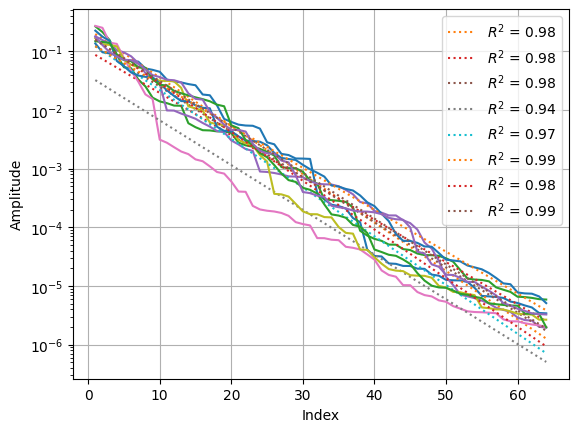

In [229]:
amp_inds = np.arange(64)+1
for _ in range(8):
    temp = np.random.choice(temperatures)
    intensity = np.random.choice(intensities)
    gsl = np.random.choice(gsls)
    loc_dict = {"temperature": temp, "intensity": intensity, "gsl": gsl}
    sorted_amps = np.sort(optimal_bw["amplitudes"].loc[loc_dict])[::-1]
    # slope, intercept, r_value, _, _ = linregress(np.log(amp_inds), np.log(sorted_amps))
    slope, intercept, r_value, _, _ = linregress(amp_inds, np.log(sorted_amps))
    plt.semilogy(amp_inds, sorted_amps)
    # plt.semilogy(amp_inds, np.exp(intercept)*amp_inds**slope, ":" ,label=f"$R^2$ = {r_value**2:.2f}")    
    plt.semilogy(amp_inds, np.exp(intercept)*np.exp(slope*amp_inds), ":", label=f"$R^2$ = {r_value**2:.2f}")

plt.xlabel("Index")
plt.ylabel("Amplitude")
plt.grid()
plt.legend()
from scipy.stats import linregress



np.float64(-3.208801866797209)